# The MEL Scale

### Frequency Sensitivity in Auditory Perception

The frequency range of the human ear spans from 20Hz to 20kHz.
Many properties of our hearing system are easier understood in the frequency domain than in the time domain, which makes Fourier spectrograms a favorite representation of acoustic signals.

However, Fourier analysis misses some important characteristics of hearing, especially the nonlinear characterisitics of frequency sensitivity:   
- frequencies close to each interfere a lot, while frequencies far apart are quite independent   
- the frequency range over which interference is prominent is small at low frequencies and much higher at high frequencies   

Based on diverse perceptual experiments it was therefore suggested to model the human hearing system using a set of non uniform auditory (band-pass) filters.  The bandwidth of these filters is called the *critical bandwidth*.  

### Auditory Filters in the cochlea

Processing in the cochlea is easiest understood as an auditory filterbank. Individual auditory nerve fibers are sensitive only to a narrow frequency range centered around the *characteristic frequency* of the corresponding nerve fiber.  Both the density of these filters and their bandwidth follow the critical band characteristics (linear at low, logarithmic at high frequencies)


In [16]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        %pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (12,4)
mpl.rcParams["savefig.dpi"] = 100
mpl.rcParams["savefig.bbox"] = 'tight'
# When the SAVE_FIG flag is set, then pictures are save along the way
SAVE_FIG = False
import librosa
from pyspch.sp.mel import *

## 1. Mel Scale Approximations

From the above it is obvious that there is not such a thing as **THE** auditory frequency scale as different experiments lead to slightly different scales:  **MEL** scale, **BARK** scale, the **ERB** scale, **1/3th octave filterbanks**, ... 

Putting small differences aside, it is often sufficient to reason as follows:   
- linear up to 1kHz with a bandwidth of 100Hz  
- logartihmic above 1 kHz
- resulting in 24 critical bands spanning the auditory frequency range

In the sequel we will use the term **mel-scale** as a generic term, and 
in order to compare different implementations we rescale each such that frequency is mapped to a number corresponding for critical band number, in particular we always map 1000.0Hz to 10.0 mel.  (Note: this is our own way of standardizing different mappings; there is no established standard)

The functions mel2hz() and hz2mel() implement a few of these mel-scale variants:
- DM(Davis and Mermelstein): as defined in the 1980 paper in which they introduce the concept of mel cepstra, one of the oldest handy approximations
- HTK: as used in the HTK and KALDI packages, based on a formula proposed by Gunnar Fant in 1959
- Slaney: as used in the MATLAB Auditory Toolbox and also used as default in the librosa library.

In Python packages librosa and torchaudio both the Slaney and HTK scales are implemented.

All 'mel'-centered code is grouped in *mel.py* in this folder 

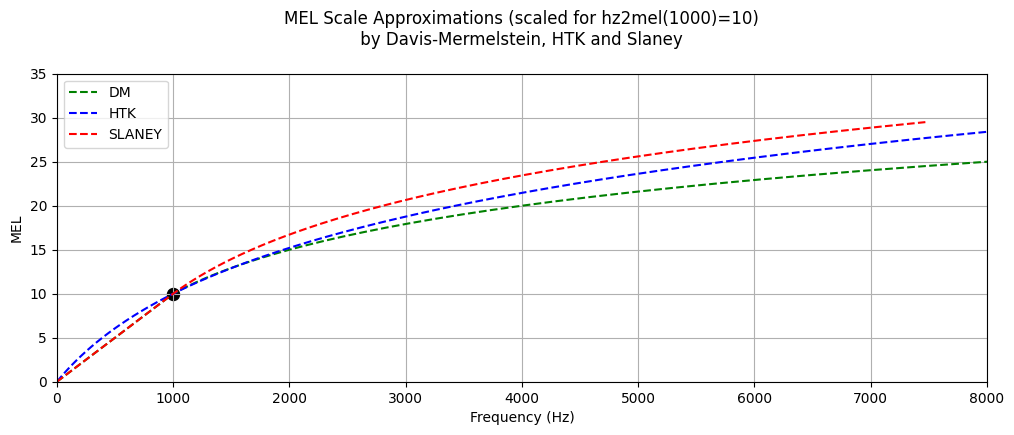

In [18]:
mels = np.arange(0.,30.,.5)
freqs_sl = mel2hz(mels,scale='SLANEY')
freqs_htk = mel2hz(mels,scale='HTK')
freqs_dm = mel2hz(mels,scale='DM')

fig1,ax1 = plt.subplots()

ax1.plot(freqs_dm,mels,'--',color='g')
ax1.plot(freqs_htk,mels,'--',color='b')
ax1.plot(freqs_sl,mels,'--',color='r')

ax1.legend(['DM','HTK','SLANEY']);

ax1.grid()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("MEL")
ax1.tick_params(axis='x')
ax1.set_title("MEL Scale Approximations (scaled for hz2mel(1000)=10)\n by Davis-Mermelstein, HTK and Slaney \n");
ax1.set_ylim([0.,35.])
ax1.set_xlim([0,8000])

ax1.scatter(1000,10,marker='o',s=75,color='k');
if SAVE_FIG : fig1.savefig("figures/mel_scale")

## 2. Mel scale and Equivalent Bandwidth
Another way to understand the mel scale is by thinking in terms of equivalent perceptual bandwidths; i.e. the range over which there is strong interference.
Below 1kHz this bandwidth is estimated to be roughly 100Hz and at higher frequencies this bandwidth linearly increases.

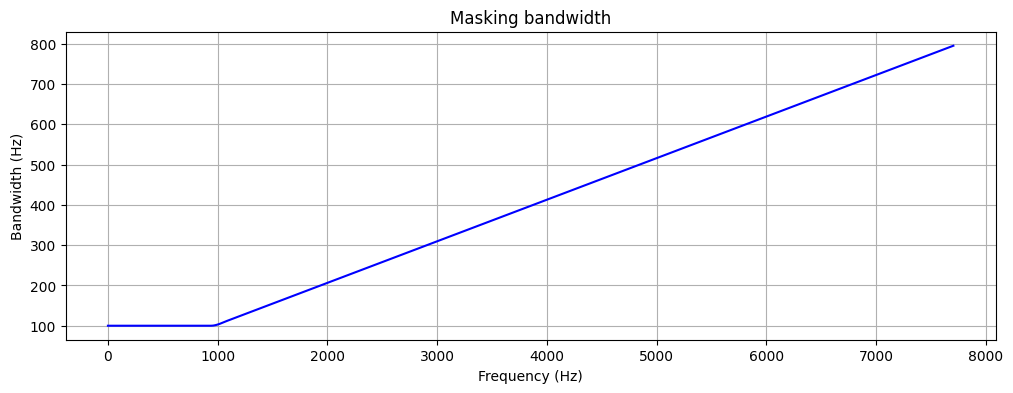

In [19]:
bw_mel = 1.
mels = np.arange(0.,30.,.2)
freqs = mel2hz(mels)
lows = mel2hz(mels-bw_mel/2)
highs = mel2hz(mels+bw_mel/2)
bw_hz = (highs-lows)
fig,ax = plt.subplots()
ax.plot(freqs,bw_hz)
ax.set_title("Masking bandwidth")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bandwidth (Hz)")
ax.grid('on')

### Labeling a mel axis with 'mel' or 'Hz' ??
Because the lack of standardization of a mel scale, we see in practice that people use 'Hz' as labels on the frequency axis and
that the non linear behavior is obvious from the tick values

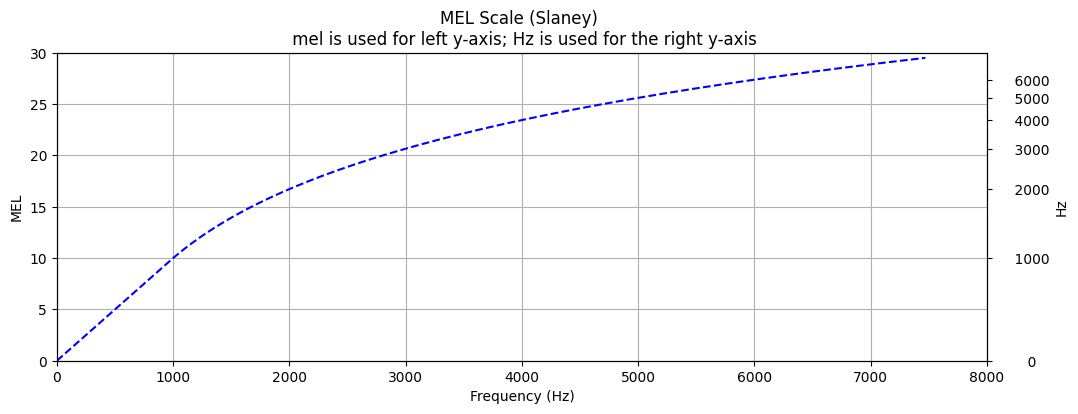

In [20]:
mels = np.arange(0.,30.,.5)
freqs = mel2hz(mels)
#
fig,ax1 = plt.subplots()
ax1.plot(freqs,mels,'--',color='b')
ax1.grid()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("MEL")
ax1.set_title('MEL Scale (Slaney) \n mel is used for left y-axis; Hz is used for the right y-axis');

y_lim = np.asarray([0.,30.])
ax1.set_ylim(y_lim)
ax1.set_xlim([0,8000])

ax2 = ax1.twinx()
#specify y2_ticks at specific Hz locations
y2_ticks = hz2mel([0,1000,2000,3000,4000,5000,6000]) 
### or use tick marks as on y1
# y2_ticks = ax1.get_yticks()
#
y2_ticklabels = ['{:.0f}'.format(mel2hz(x)).rjust(8) for x in y2_ticks]



# (matplotlib programming note) 
# you need to do the following lines in STRICT order to avoid warnings and/or plotting mistakes
# 1. set the y_ticks, 2. set the y_ticklables, 3. set the y_lim identical to axis1
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_ticklabels)
ax2.set_ylim(y_lim)
ax2.set_ylabel( 'Hz' );

## 2. MEL FILTERBANK

The primary usage of the mel-scale in speech processing is to map of a **Fourier spectrum** to a **mel spectrum** , using a **mel filterbank**.

Typically these filterbanks are designed such that overlap between adjacent bands is minimal.   The filtering itself is done by summing up the powers of Fourier spectral coefficients within a band, weighted by the filter shape.
The most common design choice is to use triangular shaped filters along the mel scale with 50% overlap.

Further Notes:
- It is also well known that the data at the fringes of the frequency range is not be very reliable. At very low frequencies there may only be 50Hz hum from electrical equipment and at high frequencies the content is highly dependent on the sampling rate and the anti-aliasing filtering that was used.  Therefore it is common practice to throw away one or several of the lowest and highest bands in speech recognition systems or alternatively to limit the frequency range of the filterbank. 
- In the filterbank design routines below we use the librosa() functions for mel filterbank design.  Arguments *fmin* and *fmax* specify the range (outer edges) of the filterbank.

### A critically spaced mel filterbank

The first filterbank that we design use a filter spacing (and bandwidth) of roughly 1 mel.
This gives us 24 channels with a range of 0 - 6300 Hz.
If we use a sampling rate of 8kHz then the upper 4 channels fall outside the usable frequency range, thus maintaining 20 channels.
Also the first channel (0-100Hz) is likely to be useless for speech recognition applications as the content is too unpredictable.
Alternatively we could set the fmin to 50 or 100Hz.

The figures show 
(1) designed centerfrequencies and bandwidth   
(2) designed filterbank (conceptual)
(3) actual interpolation weights to apply to an FFT spectrum to compute a mel spectrum and simulate the filterbank above

#### TASK: 
Design a filterbank for a sampling rate of 8kHz , using the full bandwidth and 20 channels.  Verify that this yields the same as taking the first 20 channels from the originally designed filterbank.

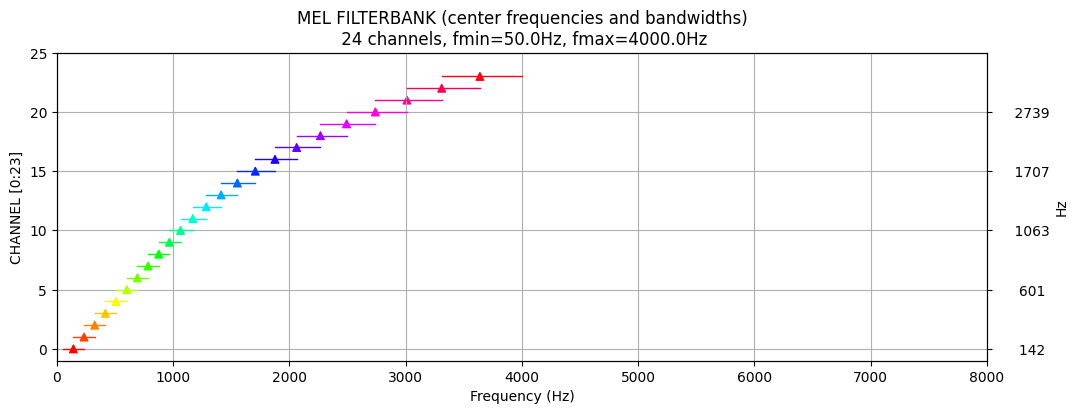

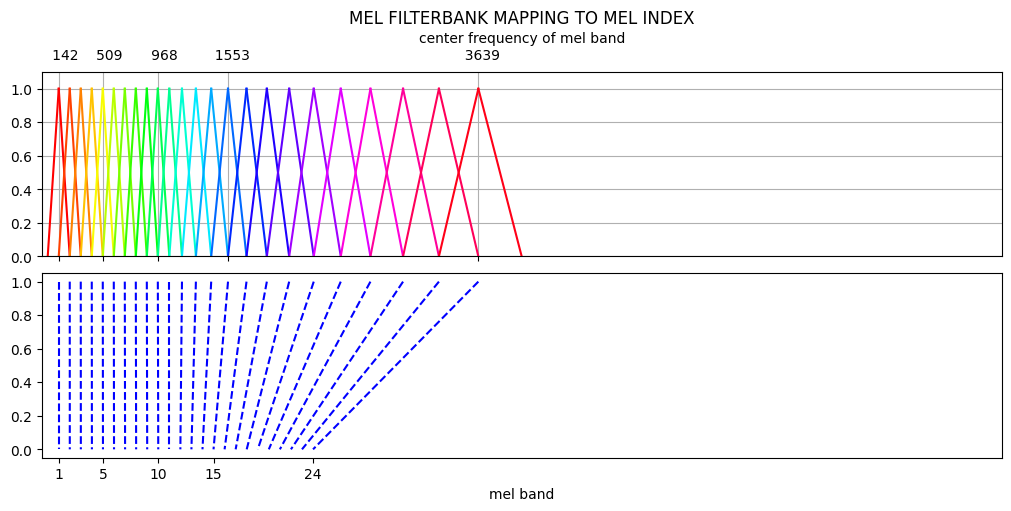

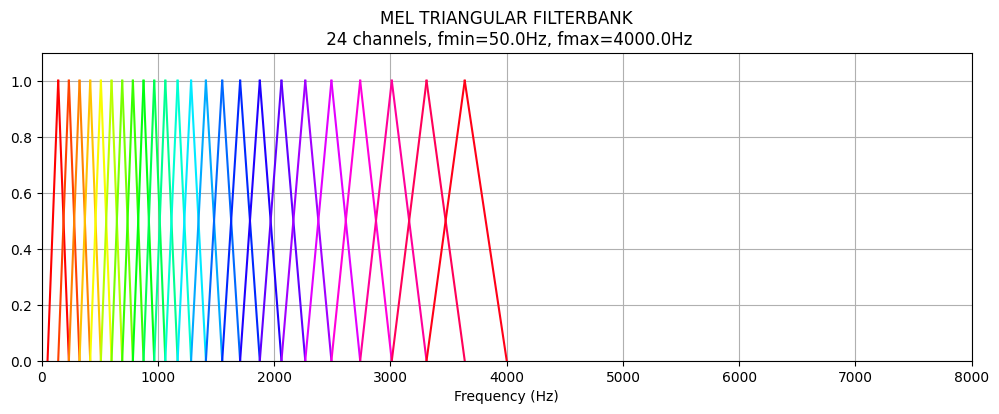

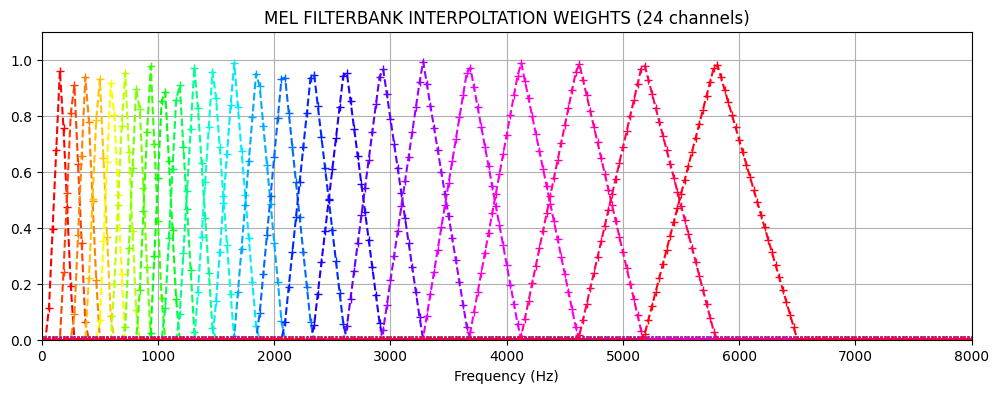

In [21]:
##  DESIGN PARAMETERS - MINIMAL NUMBER OF CHANNELS  ########
sr = 16000         # sampling rate, typically 16 or 8 kHz
n_mels = 24        # the number of mel filterbanks should not be less than 24 with 16kHz sampling or 20 channels with 8kHz sampling
                   # such design has roughly filterbank widths equal to 1 mel; less channels would imply wider bands that would smear information too much
                   # and should be no more than 64 for sr=8000, can go to 100 for sr=16000
fmin = 50.         # lower cutoff can be set to 0Hz, but 50Hz is more common in practice is there is no useful acoustic energy below 50Hz
fmax = 6500.       # higher cutoff for filterbank.  6500.Hz is an arbitrary value; it was chosen to make the first 20 bands fit nicely into the 4kHz range
##########

freqs,fbank = mel_filterbank(n_mels=n_mels,sr=sr,fmin=fmin,fmax=fmax) 
#print("MEL FBANK Center Frequencies")
#print(freqs[1:-1],"\n")
#

name = "figures/mel_filterbank"+str(n_mels)+"_"
plot_filterbank_cf_bw(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"cf")
plt.show()
plot_filterbank_mapping(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"map")
plt.show()
plot_filterbank(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"filt")
plt.show()
plot_filterbank_weights(fbank,sr=sr)
if SAVE_FIG : plt.savefig(name+"coef")
plt.show()

### A high resolution mel filterbank

A high resolution mel filterbank uses filter spacings and bandwidths that are significantly higher resolution than 1 mel.
It seems to make little sense to go beyond the resolution of our Fourier spectrum.
With some fair assumptions about sampling rate and FFT parameters (256 pt FFT for 8kHz sampling and 512pt FFT for 16kHz sampling) we can conclude that *80 channels* is a reasonable number of channels (upper limit) for a high resolution filterbank.
In the design below we set fmin to 50Hz and fmax to 6500Hz.

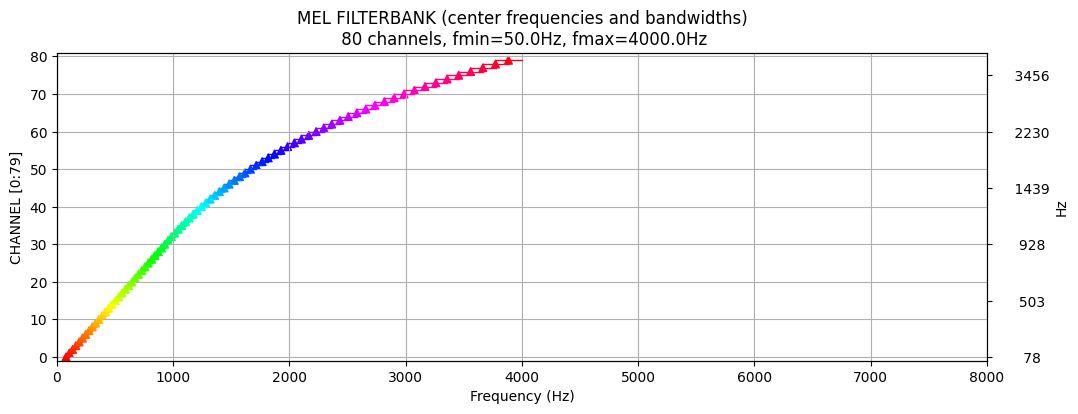

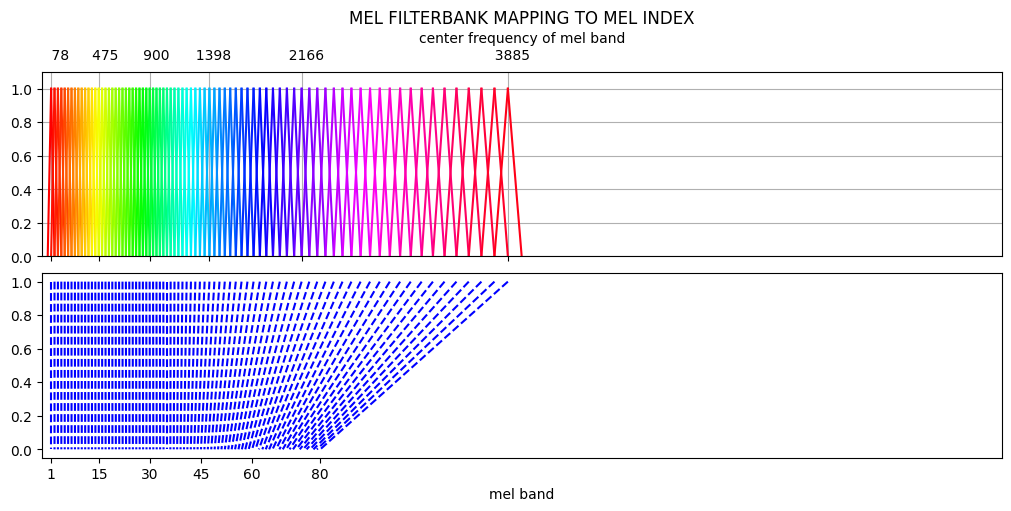

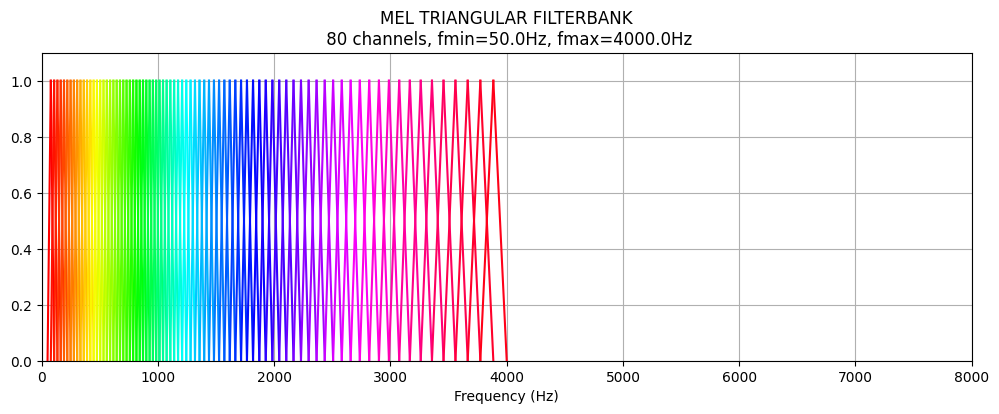

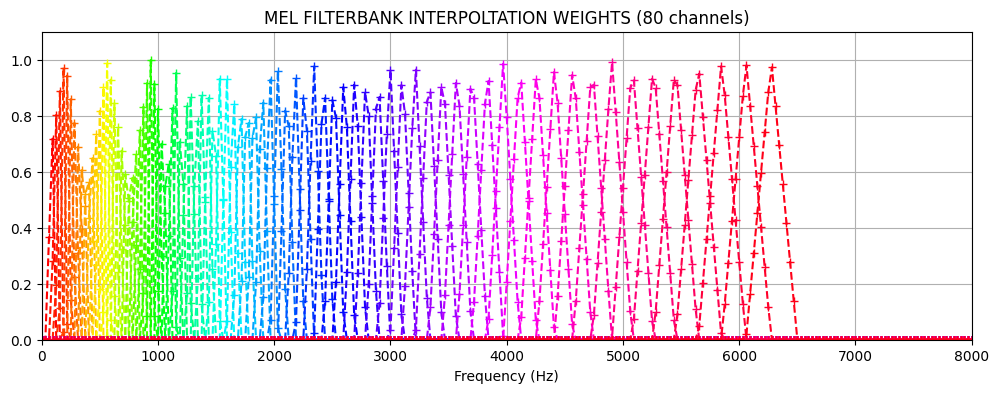

In [22]:
sr = 16000         # sampling rate, typically 16 or 8 kHz
n_mels = 80        # the number of mel filterbanks should not be less than 24 with 16kHz sampling or 20 channels with 8kHz sampling
                   # such design has roughly filterbank widths equal to 1 mel; less channels would imply wider bands that would smear information too much
                   # it should be no more than 64 for sr=8000, and can go up to 100 for sr=16000
fmin = 50.         # lower cutoff is by default set to 50Hz as no significant speech frequencies are present below this
fmax = 6500.       # will by default be 0.5*sampling_rate but with a cuttoff at 6.5kHz 
##########
freqs,fbank = mel_filterbank(n_mels=n_mels,sr=sr,fmin=fmin,fmax=fmax) 
#print("MEL FBANK Center Frequencies")
#print(freqs[1:-1],"\n")
#

name = "figures/mel_filterbank"+str(n_mels)+"_"
plot_filterbank_cf_bw(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"cf")
plt.show()
plot_filterbank_mapping(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"map")
plt.show()
plot_filterbank(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"filt")
plt.show()
plot_filterbank_weights(fbank,sr=sr)
if SAVE_FIG : plt.savefig(name+"coef")
plt.show()